## Abstract

It's been widely discussed recently whether frequency encoding here is leak or not. Someone still claim that they understand the way Santader created data, but I don't. I believe that frequency encoding somehow approximate initial (pre-noise) data, but not more. As probably many other participats, at the beginning I noticed how frequency endoding of train increace local CV, but once I plotted train frequency vs test frequency I saw how different they were. That was the moment I used famous YaG320 kernel for fake/real data. Once I applied transformation to combined (train + real test) dataset, frequency distribution for train/real test were approximately the same. This also increased my local CV. 

However, when I further investigated how target is allocated within frequency bins in train set I saw weird artifacts. Almost 30% of variables have bins without single `target=1` observation. When I tried manually replace them with 0, I got decrease in public LB score.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv') 

l3 = np.load('../input/list-of-fake-samples-and-public-private-lb-split/synthetic_samples_indexes.npy')
test = test[~test.index.isin(l3)]

coltouse = [col for col in train.columns.tolist() if col not in ['ID_code', 'target']]
all_df = pd.concat([train, test], sort=False)
for col in tqdm(coltouse):
    all_df[f'scaled_{col}'] = all_df.groupby([col])[col].transform('count')
    
train = all_df[~all_df['target'].isnull()]
test = all_df[all_df['target'].isnull()]

100%|██████████| 200/200 [01:30<00:00,  1.30it/s]


An example of artifact:

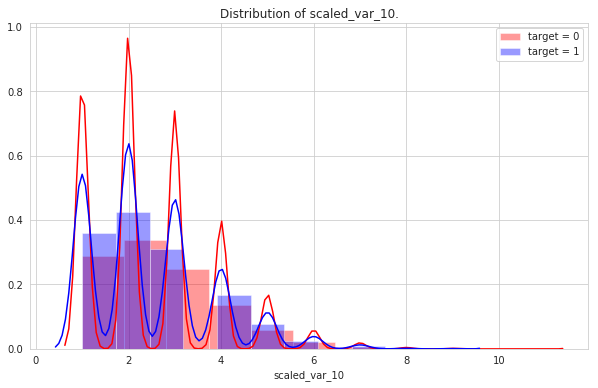

In [3]:
plt.figure(figsize=(10,6))
maxbins = train[train['target'] == 0]['scaled_var_10'].value_counts().shape[0]
plt.title("Distribution of scaled_var_10.")
sns.distplot(train[train['target'] == 0]['scaled_var_10'], color="red", kde=True, bins=maxbins, label='target = 0')
sns.distplot(train[train['target'] == 1]['scaled_var_10'], color="blue", kde=True, bins=maxbins, label='target = 1')
plt.legend(); plt.show()

In [ ]:
train[train['target']==0]['scaled_var_10'].value_counts().index, train[train['target']==1]['scaled_var_10'].value_counts().index

In [ ]:
train[train['target']==0]['scaled_var_10'].value_counts(normalize=True)

In [ ]:
train[train['target']==1]['scaled_var_10'].value_counts(normalize=True)

In [ ]:
train[train['target']==0]['scaled_var_10'].value_counts().index.symmetric_difference(train[train['target']==1]['scaled_var_10'].value_counts().index)

As we can see, there are 2 bins (10 and 11) with no single observation where `target=1`. As I said in the beginning of this kernel I tried to replace such values with 0 and got loss in public LB score. Since we applied count transfromation to combined dataset, let's look at the artifact in combined dataset.

In [ ]:
all_df[all_df['scaled_var_10']==11]

If direct replacement with `0` doesn't work (i.e. it's not oblvious leak of mapping), then apparently there are some `1` in test here. However, we feed the whole train to LGBM, algorithm will use such values (10 and 11 for var_10_count) as possible points for split and this will affect another splits as well, since LGBM believe that each observation with `var_10_count = 10 or 11` has target 0 and this is wrong. On the other, hand we know, that frequency encoding overall improves AUC, so it somehow still follows initial pre-noised data. 

I saw that some other participants succeeded in creating frequency encoded boolean variables like `freq==1` or `freq>1` which increased their scores, but again what is the logic behind such operations with respest to the way inital mapping were perfomed (i.e. combined train + real test)? Isn't it mere another *seems to approximate initial distribution* thing? Why is it working? Because we apply to combined dataset?

Another interesting point is that most of such bins located within tails (i.e. if variable has 10 unique counts, bins `[1-9]` will have `1 and 0`, whereas last bin will have only `0`). It is true for almost every variable, except for `var_68`. CPMP, for example, clipped upper bounds for frequency with 6 (i.e. `.clip(1,6)`) to deal with it.

At the end I'd like to share list of such vars with artifacts for whoever is interested. 

In [20]:
count = 0
weirdvars = []
idx = []
for col in coltouse:
    if train[train['target']==1][f'scaled_{col}'].value_counts().shape[0] != train[train['target']==0][f'scaled_{col}'].value_counts().shape[0]:
        bins = list(train[train['target']==0][f'scaled_{col}'].value_counts()\
                    .index.symmetric_difference(train[train['target']==1][f'scaled_{col}'].value_counts().index))
        totbins = train[train['target']==0][f'scaled_{col}'].value_counts().shape[0]
        print(f'Variable: {col}, Total bins = {totbins}, Bins with no target=1: {bins}')
        count+=1
        weirdvars.append(col)
        idx.extend(train[train[f'scaled_{col}'].isin(bins)].index)
print(f'Number of vars with artifacts: {count}')
print(f'Number of rows with at least one falsely var in train: {len(np.unique(idx))}')

Variable: var_10, Total bins = 11, Bins with no target=1: [10, 11]
Variable: var_11, Total bins = 10, Bins with no target=1: [9]
Variable: var_14, Total bins = 16, Bins with no target=1: [17]
Variable: var_17, Total bins = 10, Bins with no target=1: [10]
Variable: var_18, Total bins = 10, Bins with no target=1: [10]
Variable: var_20, Total bins = 11, Bins with no target=1: [11]
Variable: var_31, Total bins = 20, Bins with no target=1: [19, 20]
Variable: var_32, Total bins = 16, Bins with no target=1: [16]
Variable: var_35, Total bins = 13, Bins with no target=1: [14]
Variable: var_38, Total bins = 13, Bins with no target=1: [13]
Variable: var_41, Total bins = 11, Bins with no target=1: [11]
Variable: var_44, Total bins = 11, Bins with no target=1: [13]
Variable: var_46, Total bins = 15, Bins with no target=1: [14]
Variable: var_49, Total bins = 10, Bins with no target=1: [10]
Variable: var_52, Total bins = 13, Bins with no target=1: [13]
Variable: var_55, Total bins = 11, Bins with no 